In [1]:
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [2]:
options(warn = -1, scipen = 999)
suppressPackageStartupMessages({
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(tidyquant)
    library(pracma)
})

In [3]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("MSFT", "AAPL","AMZN","GOOG","IBM")
retornos_d <- tq_get(acoes, from = Sys.Date()-365*4) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily")
retornos_a <- tq_get(acoes, from = Sys.Date()-365*4) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)
sd_d <- retornos_d %>%
  group_by(symbol) %>%
  summarise(sd = sd(daily.returns, na.rm = T)) %>%
  spread(key = "symbol", value = sd)
cov <- retornos_d %>%
  spread(key = "symbol", value = daily.returns)
cov$date <- NULL
cov <- cov(cov, use = "na.or.complete")

`summarise()` regrouping output by 'year' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
#Nº de simulações de carteiras a se fazer
n_sim <- 5000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rexp,0.001)
pesos <- apply(pesos,2,function(x)x/sum(x))

In [5]:
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_d, cov = cov)*sqrt(252)
retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
end <- Sys.time()
end-start

Time difference of 35.1575 secs

In [6]:
#Sharpe
tx_livre_risco <- 0.0025
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)

In [7]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



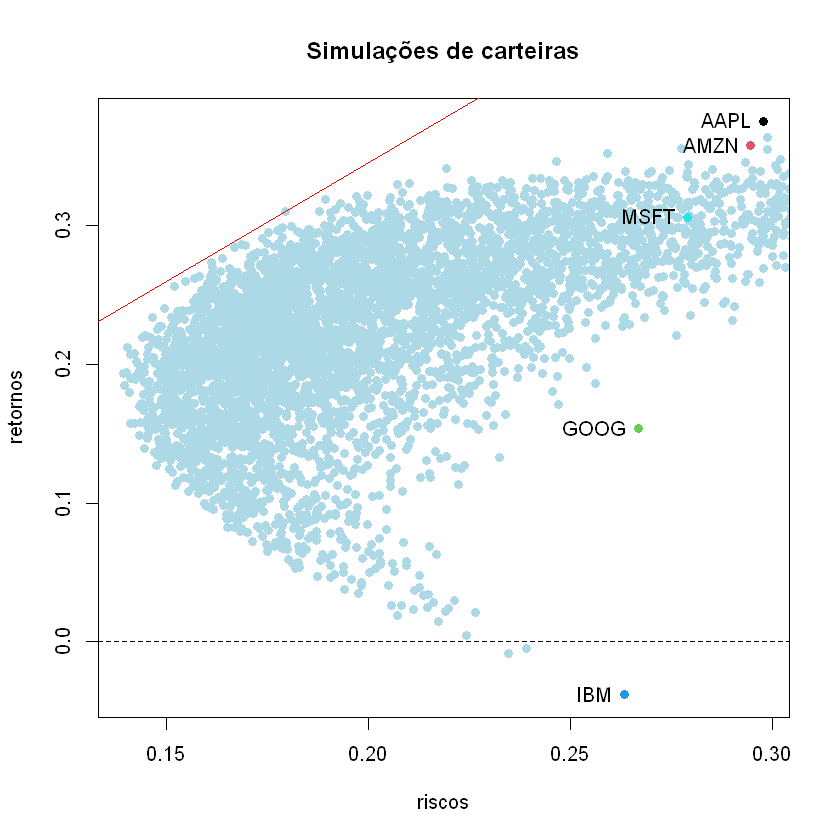

In [8]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_d*sqrt(252))),
    ylim = c(min(retorno_med), max(retorno_med)), main = "Simulações de carteiras")
points(x = sd_d*sqrt(252), y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_d*sqrt(252), y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data$sharpe), col = "red")
abline(h = 0,v = 0, lty = 2)

In [9]:
sharpe <- max(data$sharpe)
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data$retornos)
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data$riscos)
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     1.713429

Retorno Máximo 
     0.3665441

Risco Mínimo 
   0.1395751

In [10]:
#Somente ver a linha que tem o maior sharpe
positivo <- data$sharpe == sharpe
show(data[positivo,])

        riscos  retornos   sharpe
2002 0.1794217 0.3099264 1.713429


## A linha do data.frame "data" equivale a coluna da matriz de pesos

In [11]:
pesos_efi <- round(pesos[,2002]*100,2)
names(pesos_efi) <- sort(acoes)
print(pesos_efi)

 AAPL  AMZN  GOOG   IBM  MSFT 
42.69  0.01 10.40  2.77 44.12 


In [13]:
#Carteira eficiente com arredondamento de 3 casas decimais
pesos_ef <- round(pesos[,2002],3)
risco_ef <- portfolio_sd_t(sd = sd_d, cov = cov, weight = pesos_ef)*sqrt(252)
ret_ef <- portfolio_return(returns = retornos_a[,2:ncol(retornos_a)], weight = pesos_ef)
cart_ef <- data.frame(Risco = risco_ef, Retorno = ret_ef, Sharpe = (ret_ef-tx_livre_risco)/risco_ef)
cart_ef

Risco,Retorno,Sharpe
<dbl>,<dbl>,<dbl>
0.1793094,0.3098342,1.713988
